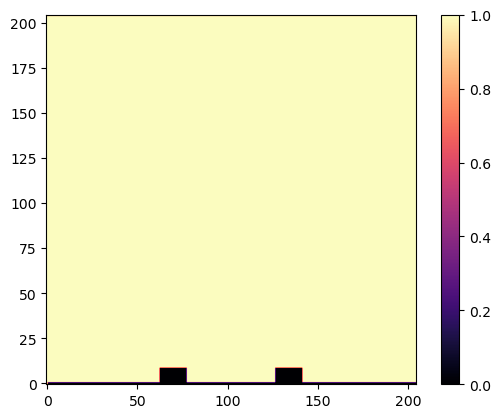

In [1]:
from input_Navier import Navier_stokes_variables
from grid import *
from difference_equation import discretization_schemes
from tqdm import tqdm
from boundary_conditions import boundary_update
from Physics import *
from initial_conditions import *
from test import *
from Visualization import *
from matplotlib import pyplot as plt

# Parameter and solution scheme setup

In [2]:
class setup_parameters:
    
    def __init__(self):
        pass
#------------------------------------------------#
    #Default value = 1: Predefined values of element length and other parameters
    #Default value = 0: User-defined values
    def call_inputvars():
        
        
        return Navier_stokes_variables.input_variables(NX = 205, NY = 205, DOMAIN_SIZE_X = 1.0, N_ITERATIONS = 1000, N_PRESSURE_POISSON_ITERATIONS = 50, TIME_STEP_LENGTH = 0.000000001, STABILITY_SAFETY_FACTOR = 0.5, KINEMATIC_VISCOSITY = 0.1, DENSITY = 1.0)
#------------------------------------------------#    
    def call_mesh_grid(NX, NY, DOMAIN_SIZE_X, DOMAIN_SIZE_Y):
        
        return mesh_grid.mesh(NX, NY, DOMAIN_SIZE_X, DOMAIN_SIZE_Y)
#------------------------------------------------#    
    def call_discretization_schemes(central_difference = True, upwind = False):
        
        if central_difference == True:
            
            first_order_discrete_space_x = discretization_schemes.central_difference_x #option: upwind
            first_order_discrete_space_y = discretization_schemes.central_difference_y #option: upwind
            
            
        else:
            if upwind == True:
                
                first_order_discrete_space_x = discretization_schemes.upwind_x #option: upwind
                first_order_discrete_space_y = discretization_schemes.upwind_y #option: upwind
                
                
        second_order_discrete_space_x = discretization_schemes.laplace
        second_order_discrete_space_y = discretization_schemes.laplace
                
        
        dscheme = [first_order_discrete_space_x, first_order_discrete_space_y, second_order_discrete_space_x,second_order_discrete_space_y  ]
        return dscheme
#------------------------------------------------#        


OUTPUT: Plotting the mesh in two dimension


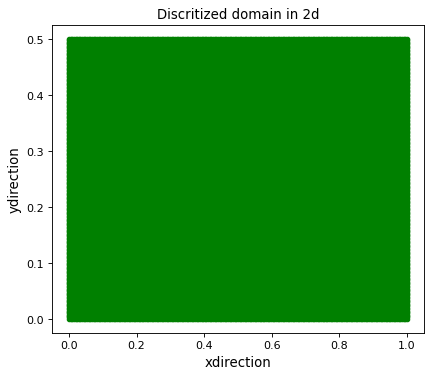

In [3]:
#Parameters

NX, NY, DOMAIN_SIZE_X, DOMAIN_SIZE_Y, N_ITERATIONS, N_PRESSURE_POISSON_ITERATIONS, TIME_STEP_LENGTH, STABILITY_SAFETY_FACTOR, KINEMATIC_VISCOSITY , DENSITY = setup_parameters.call_inputvars()
Spin_up = []
beta = 1.0
#grid
X, Y, DX, DY = setup_parameters.call_mesh_grid(NX, NY, DOMAIN_SIZE_X, DOMAIN_SIZE_Y)

# Timestep validity

# Solution loop

# Plot solution and error

In [4]:
if __name__ == '__main__':
    
#------------------------------------------------#
    #Inital_conditions
    #check out initial_conditions file
    # if zero_intialization == False, then define initial_value for matrix formation
    
    u_prev, u_tent, u_next = initial_condition.matrix_initialization(NX, NY, zero_initialization = True, intial_value = 0)
    v_prev, v_tent, v_next = initial_condition.matrix_initialization(NX, NY, zero_initialization = True, intial_value = 0)
    p_prev, p_tent, p_next = initial_condition.matrix_initialization(NX, NY, zero_initialization = True, intial_value = 0)
    if beta > 0:
        T, T_tent, T_next = initial_condition.matrix_initialization(NX, NY, zero_initialization = True, intial_value = 0)
    else:
        pass
#------------------------------------------------#
    #selecting up discretization schemes
    
    dscheme = setup_parameters.call_discretization_schemes()
    first_order_discrete_space_x = dscheme[0] 
    first_order_discrete_space_y = dscheme[1] 
    second_order_discrete_space_x = dscheme[2]
    second_order_discrete_space_y =dscheme[3]
#------------------------------------------------#  



    for _ in tqdm(range(N_ITERATIONS)):

        #Generating derivative terms for homogenous advection calculation
        
        d_u_prev__d_x = first_order_discrete_space_x(u_prev, DX)
        d_u_prev__d_y = first_order_discrete_space_y(u_prev, DX)
        d_v_prev__d_x = first_order_discrete_space_x(v_prev, DY)
        d_v_prev__d_y = first_order_discrete_space_y(v_prev, DY)
        laplace__u_prev = second_order_discrete_space_x(u_prev, DX)
        laplace__v_prev = second_order_discrete_space_y(v_prev, DY)
        
        if beta > 0:
            
            #d_T__d_x = first_order_discrete_space_x(T,DX)
            #d_T__d_y = first_order_discrete_space_y(T,DY)
            laplace_T = second_order_discrete_space_x(T, DX)
            d_T__d_x = discretization_schemes.upwind_x(T,DX)
            d_T__d_y = discretization_schemes.upwind_y(T,DY)
            
        else:
            pass
        
#------------------------------------------------#
        # Perform a tentative step by solving the momentum equation without the
        # pressure gradient
        
        #TIME_STEP_LENGTH = test_stability.test_initial_timestep_value(DX,TIME_STEP_LENGTH, KINEMATIC_VISCOSITY, STABILITY_SAFETY_FACTOR)        
        u_tent =homogenous_advection.advection_velocity_prediction_horizontal(u_prev, v_prev, d_u_prev__d_x,  d_u_prev__d_y, laplace__u_prev, KINEMATIC_VISCOSITY, TIME_STEP_LENGTH)
        v_tent =homogenous_advection.advection_velocity_prediction_vertical(v_prev, u_prev, d_v_prev__d_x,  d_v_prev__d_y, laplace__v_prev, KINEMATIC_VISCOSITY, TIME_STEP_LENGTH)  
        if beta > 0:
            T_next = homogenous_advection.advection_temperature(T, u_prev, v_prev, d_T__d_x, d_T__d_y, laplace_T, TIME_STEP_LENGTH )
        else:
            pass
#------------------------------------------------#
        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        
        u_tent = boundary_update.velocity_boundary_x(u_tent)
        v_tent = boundary_update.velocity_boundary_y(v_tent)
        
        if beta > 0:
            T_next = boundary_update.temperature_boundary(T_next)
        else:
            pass
         

#------------------------------------------------#
        d_u_tent__d_x = first_order_discrete_space_x(u_tent, DX)
        d_v_tent__d_y = first_order_discrete_space_y(v_tent, DY)
#------------------------------------------------#
#------------------------------------------------#
#------------------------------------------------#
        # Compute a pressure correction by solving the pressure-poisson equation
    
        rhs = (DENSITY / TIME_STEP_LENGTH *(d_u_tent__d_x + d_v_tent__d_y))
        p_next = pressure_poisson.pressure_solver(p_prev, DX, rhs, N_PRESSURE_POISSON_ITERATIONS)
#------------------------------------------------#
        #Generating derivative terms for velocity correction calculation

        d_p_next__d_x = first_order_discrete_space_x(p_next, DX)
        d_p_next__d_y = first_order_discrete_space_y(p_next, DY)
#------------------------------------------------#
#------------------------------------------------#
#------------------------------------------------#
        # Correct the velocities such that the fluid stays incompressible
        if beta > 0:
            bouancy = beta * T_next
            
        else:
            bouancy = 0
        
        u_next = advection_velocity_correction.advection_velocity(u_tent, d_p_next__d_x, DENSITY, TIME_STEP_LENGTH  ) + bouancy
        v_next = advection_velocity_correction.advection_velocity(v_tent, d_p_next__d_y, DENSITY, TIME_STEP_LENGTH  )       #'Add temperature part'
#------------------------------------------------#
        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        inflow_mass_rate_next = np.sum(u_next[:, 0])
        outflow_mass_rate_next = np.sum(u_next[:, -2])
        
        u_next[:, -1] =  u_next[:, -2] * inflow_mass_rate_next / outflow_mass_rate_next
        
        u_next = boundary_update.velocity_boundary_x(u_next)
        v_next = boundary_update.velocity_boundary_y(v_next)
        
        if beta > 0:
            T_next = boundary_update.temperature_boundary(T_next)
        else:
            pass
#------------------------------------------------#
        Spin_up.append((np.mean(u_next) - np.mean(u_prev))/np.mean(u_prev))
#------------------------------------------------#
        # Advance in time
    
        u_prev = u_next
        v_prev = v_next
        p_prev = p_next
        if beta > 0:
            T = T_next
        else:
            pass
#------------------------------------------------#

        # Modifying timestep based on CFL number
    
        TIME_STEP_LENGTH = test_stability.test_CFL_number_calculation(u_next, v_next, DX, DY, TIME_STEP_LENGTH) 


  0%|                                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]C:\Users\s9dhc\AppData\Local\Temp\ipykernel_15332\2255172248.py:116: RuntimeWarning: divide by zero encountered in double_scalars
  Spin_up.append((np.mean(u_next) - np.mean(u_prev))/np.mean(u_prev))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.44it/s]


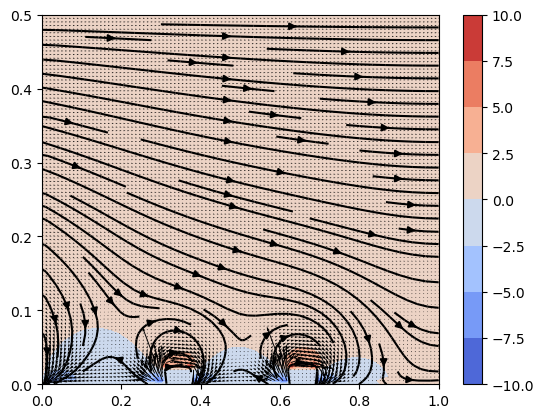

In [5]:
plt.figure()
plt.contourf(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], cmap="coolwarm")
plt.colorbar()
plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
plt.xlim((0, 1))
plt.ylim((0, 0.5))
plt.show()

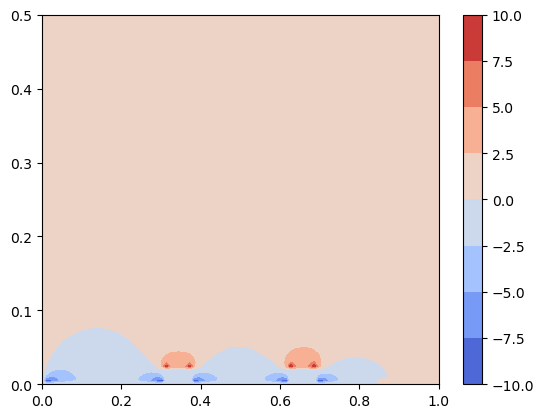

In [6]:
plt.figure()
plt.contourf(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], cmap="coolwarm")
plt.colorbar()
#plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
#plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
plt.xlim((0, 1))
plt.ylim((0, 0.5))
plt.show()

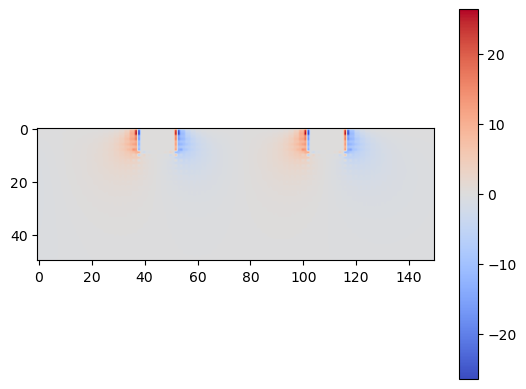

In [7]:
plt.imshow(v_next[:50,25:175], cmap = 'coolwarm')
plt.colorbar()
